<a href="https://colab.research.google.com/github/junsu122/AI_Basic/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EB%94%A5%EB%9F%AC%EB%8B%9D_%EA%B8%B0%EC%B4%88/CNN/CNN%EA%B8%B0%EB%B3%B8_Batchnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VehicleClassifier(nn.Module):
    def __init__(self):
        super(VehicleClassifier, self).__init__()

        # [과적합 튜닝 1] 데이터 증강(Augmentation) 효과를 내기 위한 강한 초기 필터링
        # 3채널(RGB) 입력 -> 32채널 출력
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # 배치 정규화

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.pool = nn.MaxPool2d(2, 2)

        # [과적합 튜닝 2] 드롭아웃 (공간적 특징의 의존성 탈피)
        self.dropout_conv = nn.Dropout2d(0.3)
        self.dropout_fc = nn.Dropout(0.5)

        # 32x32 이미지가 Pool을 2번 거치면 8x8이 됨
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 2) # 결과값 2개: [자동차일 확률, 비행기일 확률]

    def forward(self, x):
        # 특징 추출 단계 (자동차의 바퀴, 비행기의 날개 끝 등 세부 특징 포착)
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout_conv(x)

        # 일차원 벡터화
        x = x.view(-1, 64 * 8 * 8)

        # 고차원 판단 단계 (추출된 특징들의 조합으로 '탈 것'의 종류 결정)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)
        x = self.fc2(x)

        return x

model = VehicleClassifier()

100%|██████████| 170M/170M [00:05<00:00, 30.9MB/s]


Epoch 01: Loss 0.368 | Acc 84.30% | Val_Loss 0.236 | Val_Acc 89.75%
Epoch 02: Loss 0.240 | Acc 90.21% | Val_Loss 0.150 | Val_Acc 93.95%
Epoch 03: Loss 0.193 | Acc 92.08% | Val_Loss 0.153 | Val_Acc 94.50%
Epoch 04: Loss 0.176 | Acc 92.93% | Val_Loss 0.144 | Val_Acc 94.00%
Epoch 05: Loss 0.162 | Acc 93.64% | Val_Loss 0.138 | Val_Acc 94.90%
Epoch 06: Loss 0.149 | Acc 94.07% | Val_Loss 0.127 | Val_Acc 95.00%
Epoch 07: Loss 0.140 | Acc 94.53% | Val_Loss 0.127 | Val_Acc 94.80%
Epoch 08: Loss 0.134 | Acc 94.58% | Val_Loss 0.116 | Val_Acc 95.05%
Epoch 09: Loss 0.124 | Acc 95.34% | Val_Loss 0.100 | Val_Acc 95.60%
Epoch 10: Loss 0.115 | Acc 95.62% | Val_Loss 0.118 | Val_Acc 95.35%
Epoch 11: Loss 0.114 | Acc 95.43% | Val_Loss 0.108 | Val_Acc 95.95%
Epoch 12: Loss 0.112 | Acc 95.83% | Val_Loss 0.091 | Val_Acc 96.35%
Epoch 13: Loss 0.106 | Acc 96.06% | Val_Loss 0.117 | Val_Acc 95.65%
Epoch 14: Loss 0.105 | Acc 96.01% | Val_Loss 0.085 | Val_Acc 96.90%
Epoch 15: Loss 0.099 | Acc 96.42% | Val_Loss 0.0

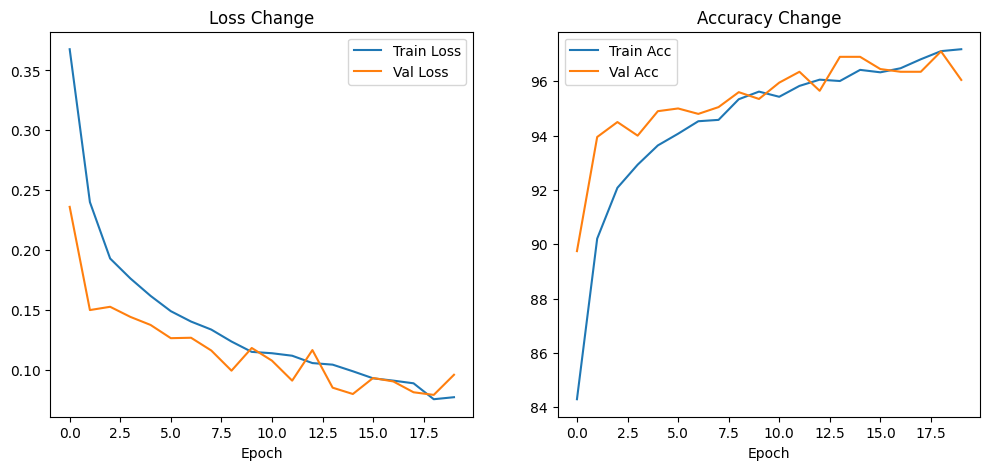

In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터 준비 및 증강 (과적합 방지 튜닝 포함)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(), # 데이터 증강: 좌우 반전
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 데이터 로드 (0: 비행기, 1: 자동차)
full_train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# 비행기(0)와 자동차(1) 클래스만 추출
def filter_indices(dataset):
    return [i for i, label in enumerate(dataset.targets) if label in [0, 1]]

train_loader = DataLoader(Subset(full_train_set, filter_indices(full_train_set)), batch_size=64, shuffle=True)
test_loader = DataLoader(Subset(full_test_set, filter_indices(full_test_set)), batch_size=64, shuffle=False)

# 2. 모델, 손실함수, 최적화 도구 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VehicleClassifier().to(device) # 앞서 만든 모델 사용
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) # L2 규제 추가

# 3. 훈련 루프 및 기록 저장
history = {'loss': [], 'val_loss': [], 'acc': [], 'val_acc': []}
epochs = 20

for epoch in range(epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # 검증(Validation) 단계
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    # 기록 업데이트
    history['loss'].append(train_loss/len(train_loader))
    history['val_loss'].append(val_loss/len(test_loader))
    history['acc'].append(100.*correct/total)
    history['val_acc'].append(100.*val_correct/val_total)

    print(f'Epoch {epoch+1:02d}: Loss {history["loss"][-1]:.3f} | Acc {history["acc"][-1]:.2f}% | '
          f'Val_Loss {history["val_loss"][-1]:.3f} | Val_Acc {history["val_acc"][-1]:.2f}%')

# 4. 결과 그래프 시각화
plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss Change')
plt.xlabel('Epoch')
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history['acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Accuracy Change')
plt.xlabel('Epoch')
plt.legend()

plt.show()

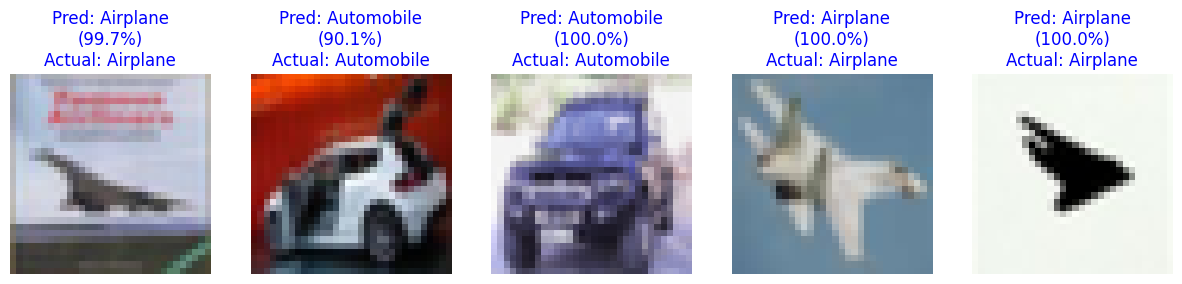

In [3]:
import torch.nn.functional as F

def visualize_predictions(model, test_loader, device, num_images=5):
    model.eval()  # 평가 모드 (드롭아웃 OFF)
    classes = ['Airplane', 'Automobile']

    # 테스트 로더에서 하나의 배치를 가져옴
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # 모델 예측
    with torch.no_grad():
        outputs = model(images)
        probabilities = F.softmax(outputs, dim=1) # 확률값으로 변환
        _, predicted = torch.max(outputs, 1)

    # 시각화
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)

        # 이미지 역정규화 (보여주기 위함)
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = img * 0.5 + 0.5 # Normalize 해제 (mean=0.5, std=0.5였을 경우)
        img = np.clip(img, 0, 1)

        plt.imshow(img)

        # 예측 결과와 확률 계산
        pred_idx = predicted[i].item()
        actual_idx = labels[i].item()
        prob = probabilities[i][pred_idx].item() * 100

        # 제목 색상 설정 (맞으면 파란색, 틀리면 빨간색)
        color = 'blue' if pred_idx == actual_idx else 'red'

        plt.title(f"Pred: {classes[pred_idx]}\n({prob:.1f}%)\nActual: {classes[actual_idx]}",
                  color=color)
        plt.axis('off')

    plt.show()

# 함수 실행
visualize_predictions(model, test_loader, device, num_images=5)